In [2]:
import numpy as np

import functools
import operator

from typing import Callable

x = [1, 2, 3]
y = [3, 1, 4]
SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")

In [3]:
def generate_y_coordinates(x_coordinates: list[float], func: Callable[[float], float], fill_value: float = np.nan) -> list[float]:
    y_coordinates = []
    for xv in x_coordinates:
        try:
            y_coordinates.append(func(xv))
        except ValueError:
            y_coordinates.append(fill_value)
    return y_coordinates

In [4]:
def interpolate_lagrange(x_coordinates: list[float], y_coordinates: list[float]) -> np.poly1d:
    if len(x_coordinates) != len(y_coordinates):
        raise ValueError(f"x and y must be of the same size {len(x_coordinates)} {len(y_coordinates)}.")

    iterations = len(x_coordinates)
    lagrange_polynomials = [1] * iterations

    for i in range(iterations):
        for j in range(iterations):
            if j == i: continue
            lagrange_polynomials[i] *= np.poly1d([1, -x_coordinates[j]]) / (x_coordinates[i] - x_coordinates[j])

    return sum(yv * polynomial for yv, polynomial in zip(y_coordinates, lagrange_polynomials))


x = [1, 2, 3]
y = [3, 1, 4]
interpolate_lagrange(x, y)

poly1d([ 2.5, -9.5, 10. ])

In [5]:
def divided_differences(x_coordinates: list[float], y_coordinates: list[float]) -> np.array:
    if len(x_coordinates) != len(y_coordinates):
        raise ValueError(f"x and y must be of the same size {len(x_coordinates)} {len(y_coordinates)}.")

    dimension = len(x_coordinates)
    coefficients = np.zeros([dimension, dimension])
    coefficients[:, 0] = y_coordinates

    for j in range(1, dimension):
        for i in range(dimension - j):
            coefficients[i][j] = (coefficients[i + 1, j - 1] - coefficients[i, j - 1]) / (x_coordinates[i + j] - x_coordinates[i])

    return coefficients


x = [1, 2, 3]
y = [3, 1, 4]
divided_differences(x, y)

array([[ 3. , -2. ,  2.5],
       [ 1. ,  3. ,  0. ],
       [ 4. ,  0. ,  0. ]])

In [6]:

def interpolate_newton(x_coordinates: list[float], y_coordinates: list[float]) -> np.poly1d:
    if len(x_coordinates) != len(y_coordinates):
        raise ValueError(f"x and y must be of the same size {len(x_coordinates)} {len(y_coordinates)}.")
    
    coefficients = divided_differences(x_coordinates, y_coordinates)[0, :]
    iterations = len(x_coordinates)

    result = np.poly1d([coefficients[0]])
    
    for n in range(1, iterations):
        result += functools.reduce(operator.mul, (np.poly1d([1, -x_coordinates[k]]) for k in range(n))) * coefficients[n]
    return result


x = [1, 2, 3]
y = [3, 1, 4]
interpolate_newton(x, y)

poly1d([ 2.5, -9.5, 10. ])

In [7]:
def interpolate_neville(x_coordinates: list[float], y_coordinates: list[float], value: float) -> float:
    if len(x_coordinates) != len(y_coordinates):
        raise ValueError(f"x and y must be of the same size {len(x_coordinates)} {len(y_coordinates)}.")

    iterations = len(x_coordinates)
    polynomials = y_coordinates

    for j in range(1, iterations):
        for i in range(iterations - j):
            numerator = (value - x_coordinates[i + j]) * polynomials[i] + (x_coordinates[i] - value) * polynomials[i + 1]
            denominator = x_coordinates[i] - x_coordinates[i + j]
            polynomials[i] = numerator / denominator
    return polynomials[0]

interpolate_neville(x, y, 1.5)

1.375

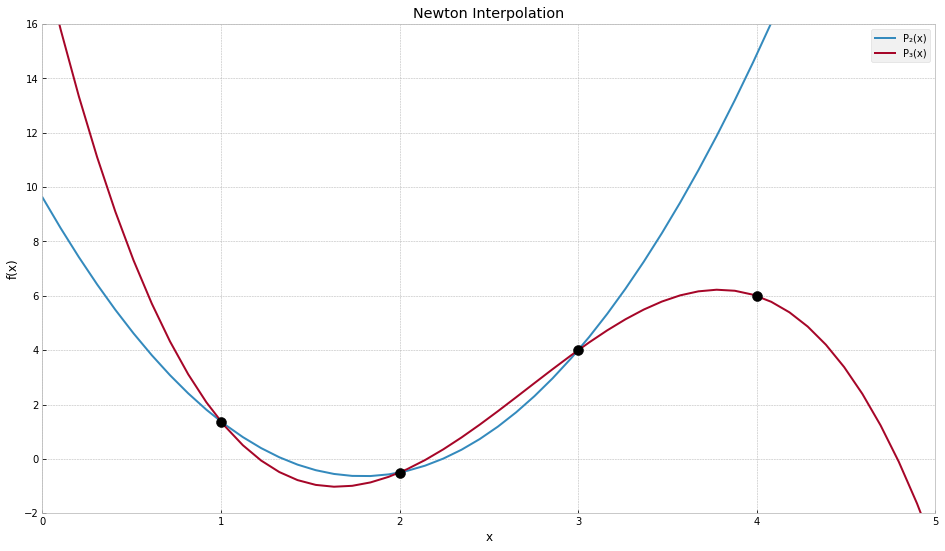

In [8]:
import matplotlib.pyplot as plt

plt.style.use("bmh")

figure, axes = plt.subplots(1, 1, figsize=(16, 9))

axes.set_facecolor("#fff")
axes.set_xlim(0, 5)
axes.set_ylim(-2, 16)
axes.set_ylabel("f(x)")
axes.set_xlabel("x")
axes.set_title("Newton Interpolation")

x_smooth = np.linspace(0, 5, 50)

func = interpolate_newton(x, y)
axes.plot(x_smooth, generate_y_coordinates(x_smooth, func), label="P2(x)".translate(SUB))

func2 = interpolate_newton(x + [4], y + [6])
axes.plot(x_smooth, generate_y_coordinates(x_smooth, func2), label="P3(x)".translate(SUB))

axes.scatter(x + [4], y + [6], c="k", s=100, zorder=3)
axes.legend()